In [1]:
import sys
sys.path.append('/home/pmontesa/code/geoscitools')
import atl08lib
import maplib
import pandas as pd
import geopandas as gpd
import csv

%matplotlib inline

In [2]:
import os
os.sys.path.append('/home/pmontesa/code/icesat2')
import FilterUtils

Misc info:
https://colab.research.google.com/github/giswqs/qgis-earthengine-examples/blob/master/Folium/ee-api-folium-setup.ipynb

### After CMR process on DaskHub, insert ADAPT path across list of granules and run extraction (and, optionally, filtering) with shell script
pdsh -g ilab,forest do_extract_filter_atl08.sh \"2018 2019 2020 2021\" /att/nobackup/pmontesa/userfs02/data/icesat2/list_atl08.005 senegal
- Still need to run this

pdsh -g ilab,forest do_extract_filter_atl08.sh \"2018 2019 2020 2021\" /att/nobackup/pmontesa/userfs02/data/icesat2/list_atl08.005 senegal_no_filt

In [5]:
SITENAME = 'senegal_20m'
ATL08_VERSION = 'atl08.006'
DIR_ATLAS = '/css/icesat-2/ATLAS'
DATA_DIR = '/explore/nobackup/people/pmontesa/userfs02/data/icesat2'

In [ ]:
# Get granules from CMR, and make list of ADAPT paths

SITEDIR = f'/explore/nobackup/people/pmontesa/userfs02/data/icesat2/{ATL08_VERSION}/{SITENAME}'
LISTSTEM = f'list_{ATL08_VERSION}_{SITENAME}'
f_list = pd.read_csv(os.path.join(SITEDIR, f'{LISTSTEM}_granules_cmr'), header=None)[0].to_list()

for YEAR in range(2018,2023):
    
    print(YEAR)
    h5_list_year = [os.path.join(f'{DIR_ATLAS}/{ATL08_VERSION.upper()}', 
                  '.'.join([f.split('_')[1][0:4], f.split('_')[1][4:6], f.split('_')[1][6:8]]),
                  f
                 ) for f in f_list if 'ATL08_'+str(YEAR) in f]
    #[print(f) for f in f_list if 'ATL08_'+str(YEAR) in f]

    with open(os.path.join(SITEDIR,LISTSTEM+'_'+str(YEAR)),'w') as myfile:
        wr = csv.writer(myfile, delimiter ='\n')
        wr.writerow(h5_list_year)

#### Build ATL08 geodataframe from extracted CSVs that were heavily filtered with land-cover specific thresholds for h_can (canopy height)

In [6]:
main_dir = f'{DATA_DIR}/{ATL08_VERSION}/{SITENAME}'
atl08_gdf = pd.concat([atl08lib.atl08_io(main_dir, str(YEAR), DO_PICKLE=False, LENGTH_SEG=20) for YEAR in range(2018, 2022)])
bname1 = os.path.basename(main_dir)
dirname1 = os.path.basename(main_dir)
atl08_gdf.to_file(os.path.join(main_dir, dirname1 + bname1 + '.gpkg'), driver='GPKG')
atl08_gdf.info()

Building list of ATL08 csvs...
12
Creating pandas data frame...
Creating a gdf for 2018 @ 20m...
Building list of ATL08 csvs...
57
Creating pandas data frame...
Creating a gdf for 2019 @ 20m...
Building list of ATL08 csvs...
51
Creating pandas data frame...
Creating a gdf for 2020 @ 20m...
Building list of ATL08 csvs...
44
Creating pandas data frame...
Creating a gdf for 2021 @ 20m...
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 672315 entries, 0 to 215629
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   lon_20m       672315 non-null  float64 
 1   lat_20m       672315 non-null  float64 
 2   h_can_20m     672315 non-null  float64 
 3   lon           672315 non-null  float64 
 4   lat           672315 non-null  float64 
 5   h_can         672315 non-null  float64 
 6   h_max_can     672315 non-null  float64 
 7   h_te_best     672315 non-null  float64 
 8   rh25          672315 non-null  float64

#### Make an interactive map to view the heavily filtered set of ATL08 obs.
make sure to set SAMP_FRAC so you dont map all the points

In [7]:
%%time
SRLITE_FOOTPRINTS_FN = '/explore/nobackup/people/pmontesa/userfs02/projects/srlite/misc/footprints_srlite-0.9.9.gpkg'
STEREOPAIR_CHM_FOOTPRINTS_FN = '/explore/nobackup/people/pmontesa/userfs02/projects/stereopair_chm/footprints/footprints_stereopair_chm.gpkg'
TANANA_2014_STEREOPAIR_FOOTPRINTS_FN = '/explore/nobackup/people/zwwillia/dataCollections/CHM_support/WorldView/Tanana/AK_2014_WV_All_stereopairs.gpkg'
SAMP_FRAC=1
# This is the footprints vector of the ~2m HRSI DSM-derived "CHM" data we are playing with..just for reference
#CHM_FOOTPRINTS_FN = '/adapt/nobackup/pmontesa/chm_work/hrsi_chm_senegal/merge.shp'
#maplib.MAP_ATL08_FOLIUM(atl08_gdf.sample(frac=SAMP_FRAC), MAP_COL='h_can', DO_NIGHT=False, LAYER_FN = CHM_FOOTPRINTS_FN, RADIUS=3)
# Senegal: -15:-13, 13:14
maplib.MAP_ATL08_FOLIUM(atl08_gdf.cx[-151:-146, 64:65].sample(frac=SAMP_FRAC), MAP_COL='h_can', GROUP_COL='y', DO_NIGHT=False, 
                        LAYER_FN = STEREOPAIR_CHM_FOOTPRINTS_FN, RADIUS=3)

ValueError: Location values cannot contain NaNs.

In [ ]:
gpd.read_file(STEREOPAIR_CHM_FOOTPRINTS_FN).pairname.to

In [57]:
class_values = [ 0, 111, 113, 112, 114, 115, 116, 121, 123, 122, 124, 125, 126, 20, 30, 90, 100, 60, 40, 50, 70, 80, 200] 
class_names = ['No data',
'Closed forest\nevergreen needle',
'Closed forest\ndeciduous needle',
'Closed forest\nevergreen broad',
'Closed forest\ndeciduous broad',
'Closed forest\nmixed', 'Closed forest\nunknown',
'Open forest\nevergreen needle',
'Open forest\ndeciduous needle',
'Open forest\nevergreen_broad',
'Open forest\ndeciduous_broad',
'Open forest\nmixed', 'Open forest\nunknown', 'Shrubs',
'Herbaceous', 'Herbaceous\nwetleand',
'Moss/lichen', 'Bare/sparse',
'Cultivated/managed',
'Urban/built', 'Snow/ice',
'Permanent\nwater', 'Open sea']

landcover_remap_dict = dict(zip(class_values, class_names))
atl08_gdf['seg_landcov_names'] = atl08_gdf['seg_landcov'].replace(landcover_remap_dict)

In [60]:
atl08_gdf.head()

,lon,lat,h_can_20m,lon_100m,lat_100m,h_can,h_max_can,h_te_best,rh25,rh50,...,rh90,seg_landcov,seg_cover,sol_el,granule_name,y,m,doy,geometry,seg_landcov_names
1,-12.046193,12.833762,11.272141,-12.046211,12.833583,12.083221,12.509903,219.956467,6.575424,7.902359,...,10.431381,114,67,-38.081509,ATL08_20181021040123_03440107_005_01.h5,2018,10,294,POINT (-12.04619 12.83376),Closed forest\ndeciduous broad
2,-12.046211,12.833583,12.083221,-12.046211,12.833583,12.083221,12.509903,219.956467,6.575424,7.902359,...,10.431381,114,67,-38.081509,ATL08_20181021040123_03440107_005_01.h5,2018,10,294,POINT (-12.04621 12.83358),Closed forest\ndeciduous broad
3,-12.046231,12.833404,11.330597,-12.046211,12.833583,12.083221,12.509903,219.956467,6.575424,7.902359,...,10.431381,114,67,-38.081509,ATL08_20181021040123_03440107_005_01.h5,2018,10,294,POINT (-12.04623 12.83340),Closed forest\ndeciduous broad
4,-12.046250,12.833223,10.599747,-12.046211,12.833583,12.083221,12.509903,219.956467,6.575424,7.902359,...,10.431381,114,67,-38.081509,ATL08_20181021040123_03440107_005_01.h5,2018,10,294,POINT (-12.04625 12.83322),Closed forest\ndeciduous broad
5,-12.069599,12.603932,13.303101,-12.069637,12.603572,11.469986,13.303101,131.851913,3.155334,4.147751,...,8.726227,114,64,-38.075016,ATL08_20181021040123_03440107_005_01.h5,2018,10,294,POINT (-12.06960 12.60393),Closed forest\ndeciduous broad


In [98]:
import plotnine
from plotnine import ggplot, aes, geom_histogram, geom_point, geom_smooth, geom_bin2d, geom_abline, xlim, ylim, labs, theme_minimal, theme_bw, facet_wrap, scale_fill_manual
plotnine.options.figure_size = (10, 5)

atl08_gdf_melted = pd.melt(atl08_gdf, id_vars =['lon', 'lat', 'seg_landcov_names'], value_vars =['h_can', 'h_can_20m']) 
print(atl08_gdf_melted.head())

         lon        lat               seg_landcov_names variable      value
0 -12.046193  12.833762  Closed forest\ndeciduous broad    h_can  12.083221
1 -12.046211  12.833583  Closed forest\ndeciduous broad    h_can  12.083221
2 -12.046231  12.833404  Closed forest\ndeciduous broad    h_can  12.083221
3 -12.046250  12.833223  Closed forest\ndeciduous broad    h_can  12.083221
4 -12.069599  12.603932  Closed forest\ndeciduous broad    h_can  11.469986


### ATL08 20m better represents shorter stature veg heights

/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 637'. Pick better value with 'binwidth'.
/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/plotnine/facets/facet.py:399: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


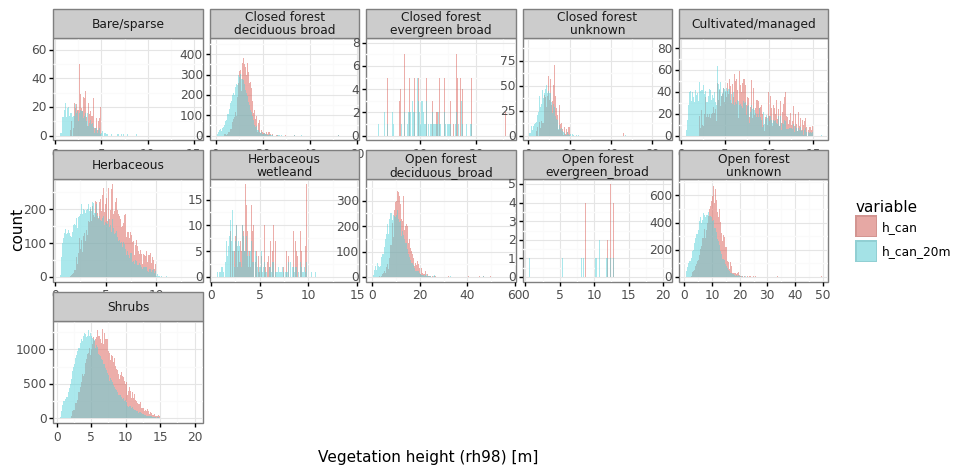

<ggplot: (1460223767697)>

In [100]:
    (
        ggplot(atl08_gdf_melted)  # What data to use
        + geom_histogram(aes(x='value', fill='variable'), alpha=0.5, position='identity' )
        #+ geom_histogram(aes(x='h_can_20m'), alpha=0.5, fill='green' )
        #+ geom_histogram(aes(x='h_can'), alpha=0.5 , fill='red')
        + theme_bw()
        + facet_wrap("~ seg_landcov_names", ncol=5, scales='free')
        + labs(x='Vegetation height (rh98) [m]')

    )

/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/gpfsm/ccds01/home/appmgr/app/jupyterhub/ilab/kernel/lib/python3.7/site-packages/plotnine/facets/facet.py:399: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


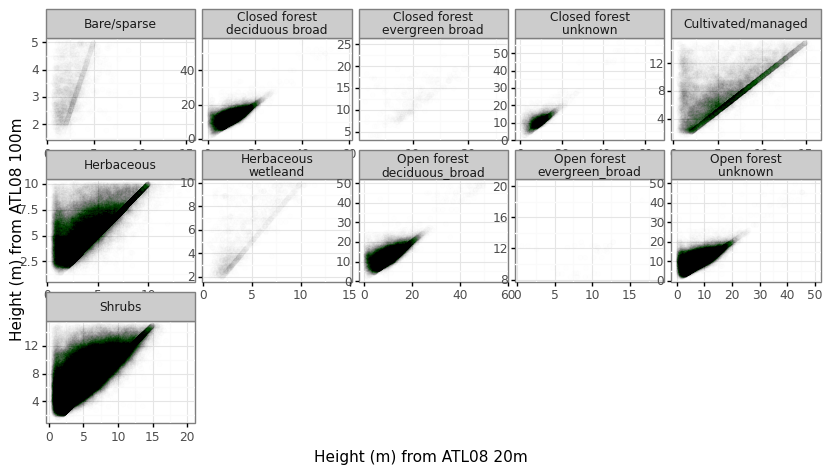

<ggplot: (1460233315065)>

In [77]:
(
    ggplot(atl08_gdf)  # What data to use
    + geom_point(aes(x='h_can_20m', y='h_can'), alpha=0.005, fill='green' )
    + facet_wrap("~ seg_landcov_names", ncol=5, scales='free')
    + theme_bw()
    +labs(y='Height (m) from ATL08 100m', x='Height (m) from ATL08 20m')
)